In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import lxml
import seaborn as sns
from scipy.stats import norm
from scipy import stats
import researchpy as rp
import warnings
warnings.filterwarnings('ignore')

El objetivo es comparar y visualizar contagios segmentados por distrito, importamos los datos de la pagina web del Servel

In [54]:
webDistritosChile = requests.get("https://www.servel.cl/territorios-electorales")
listaDistritosChile = pd.read_html(webDistritosChile.text)
dfDistritos = pd.DataFrame(listaDistritosChile[9])

In [55]:
dfDistritos = pd.DataFrame()
lista=[]

In [56]:
for i in range(len(listaDistritosChile)):
        tablas = listaDistritosChile[i]
        lista.append(tablas)
        dfDistritos = pd.concat(lista)
        
dfDistritos.columns = ['Cir_Senatorial', 'Distrito', 'Cir_Provincial', 'Comuna'] 

In [57]:
dfDistritos=dfDistritos.drop([0],axis=0)
dfDistritos.describe()

,Cir_Senatorial,Distrito,Cir_Provincial,Comuna
count,346,346,346,346
unique,16,28,66,346
top,7,6,CAUTIN II,TOCOPILLA
freq,52,26,19,1


Además necesitamos los datos de contagios, obtenidos de Data Product 1 - Casos totales por comuna incremental.

In [58]:
casos = pd.read_csv('Covid-19.csv')
casos['Comuna'] = casos['Comuna'].str.upper()
casos = casos.dropna(subset=['Tasa'])
casos.head(5)

,Region,Codigo region,Comuna,Codigo comuna,Poblacion,2020-03-30,2020-04-01,2020-04-03,2020-04-06,2020-04-08,...,2021-07-09,2021-07-12,2021-07-16,2021-07-19,2021-07-23,2021-07-26,2021-07-30,2021-08-02,2021-08-06,Tasa
0,Arica y Parinacota,15,ARICA,15101.0,247552.0,6.0,6.0,12.0,41.0,63.0,...,28532.0,28688.0,28995.0,29117.0,29158.0,29203.0,29242.0,29302.0,29348.0,11855.3
1,Arica y Parinacota,15,CAMARONES,15102.0,1233.0,0.0,0.0,0.0,0.0,0.0,...,65.0,65.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,5352.8
2,Arica y Parinacota,15,GENERAL LAGOS,15202.0,810.0,0.0,0.0,0.0,0.0,0.0,...,87.0,87.0,87.0,87.0,87.0,87.0,87.0,87.0,87.0,10740.7
3,Arica y Parinacota,15,PUTRE,15201.0,2515.0,0.0,0.0,0.0,0.0,0.0,...,194.0,195.0,195.0,196.0,196.0,196.0,198.0,198.0,198.0,7872.8
5,Tarapacá,1,ALTO HOSPICIO,1107.0,129999.0,0.0,0.0,0.0,5.0,6.0,...,14964.0,15007.0,15085.0,15118.0,15179.0,15231.0,15273.0,15322.0,15410.0,11853.9


Para comparar contagios distritos, segmentamos por la Región Metropolitana, ya que cuenta con mayor cantidad de éstos. Y la comparación inicial la realizaremos a través de la "Tasa" (número de casos confirmados por cada 100 mil habitantes de una población). Para lo cual unimos en un Data Frame la información de las 2 fuentes.

In [59]:
distritosMetropolitana = dfDistritos[dfDistritos.Distrito.isin(['8','9','10','11','12','13','14'])]

casosMetropolitana = casos[casos.Region.isin(["Metropolitana"])]

print(distritosMetropolitana['Comuna'].describe())
print(casosMetropolitana['Comuna'].describe())

count               52
unique              52
top       LO BARNECHEA
freq                 1
Name: Comuna, dtype: object
count               52
unique              52
top       LO BARNECHEA
freq                 1
Name: Comuna, dtype: object


In [60]:
df_Metropolitana = pd.merge(distritosMetropolitana, casosMetropolitana)
df_Metropolitana.groupby("Distrito")['Tasa'].describe()

,count,mean,std,min,25%,50%,75%,max
Distrito,,,,,,,,
10,5.0,10361.460000,3096.179239,6222.5,8673.000,10197.20,12917.800,13796.8
11,4.0,6531.175000,1150.561444,5379.5,5661.050,6473.40,7343.525,7798.4
12,5.0,11313.940000,1459.041817,10008.6,10564.500,10912.50,11302.700,13781.4
13,6.0,11534.933333,990.285235,10133.0,10833.975,11773.25,12227.050,12630.9
14,13.0,9513.023077,1242.562960,6575.2,8814.200,9994.00,10398.000,10794.2
8,8.0,8919.175000,983.301119,8122.1,8401.625,8570.70,8927.000,11167.8
9,8.0,11558.712500,2087.255168,8824.5,10156.900,11155.90,12808.825,15162.9


Realizamos test de normalidad a la variable Tasa para determinar si podemos aplicar ciertos métodos de comparación entre distritos.

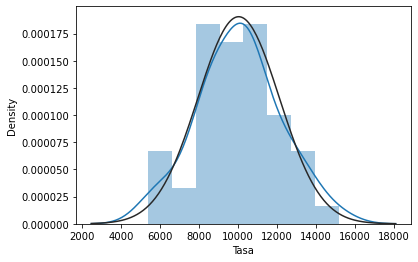

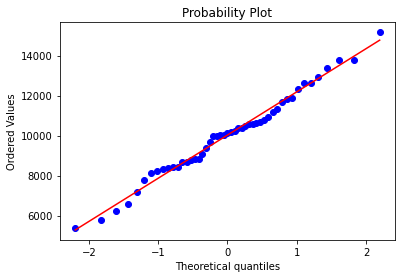

In [61]:
sns.distplot(df_Metropolitana['Tasa'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_Metropolitana['Tasa'], plot=plt)

In [62]:
Tasa = df_Metropolitana['Tasa']
shapiro_test = stats.shapiro(Tasa)
shapiro_test

ShapiroResult(statistic=0.9870940446853638, pvalue=0.8637658357620239)

El test realizado no muestra evidencias para rechazar la hipótesis de que los datos se distribuyen de forma normal, ya que pvalue es superior a 0.05.

Visualizamos la distribución de la variable Tasa segmentado por distrito.

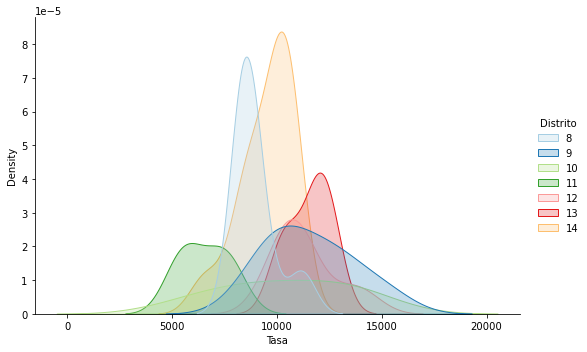

In [63]:
sns.displot(data=df_Metropolitana, x='Tasa', hue='Distrito', kind='kde', fill=True, palette=sns.color_palette("Paired", 7), 
            height=5, aspect=1.5);

Realizamos la Prueba de Levene para dos muestras, entre distritos 8 y 14 para verificar si existe homogeneidad de varianza entre estos distritos

In [64]:
dis14 = df_Metropolitana[(df_Metropolitana['Distrito'] == '14')]
dis14.reset_index(inplace= True)

dis8 = df_Metropolitana[(df_Metropolitana['Distrito'] == '8')]
dis8.reset_index(inplace= True)

In [65]:
stats.levene(dis14['Tasa'], dis8['Tasa'])

LeveneResult(statistic=0.7393970367289141, pvalue=0.40057414591291507)

p-value es 0.4005 por lo que podemos determinar que existe homogeneidad de varianza entre los distritos 8 y 14. Por lo que, el análisis lo realizaremos entre éstos.

Para la implementación del gráfico utilizamos el Data Frame proveniente de, Data Product 2 - Casos totales por comuna, transformamos el formato Fecha y segmentamos por los distritos seleccionados.

In [66]:
df_Distritos = pd.read_csv('df_Distritos.csv')

In [74]:
df_Distritos['Fecha'] = pd.to_datetime(df_Distritos['Fecha'])
df_Distritos.head(3)

,Unnamed: 0,Region,Codigo region,Comuna,Codigo comuna,Poblacion,Casos Confirmados,Fecha,CIRCUNSCRIPCIÓN SENATORIAL,DISTRITO,CIRCUNSCRIPCIÓN PROVINCIAL,COMUNA,comuna_residencia,Promedio movil
0,82,Metropolitana,13,Alhue,13502.0,7405.0,0.0,2020-03-30,7.0,14.0,MELIPILLA,ALHUE,Alhué,NaN
1,83,Metropolitana,13,Buin,13402.0,109641.0,7.0,2020-03-30,7.0,14.0,MAIPO,BUIN,Buin,NaN
2,84,Metropolitana,13,Calera de Tango,13403.0,28525.0,6.0,2020-03-30,7.0,14.0,MAIPO,CALERA DE TANGO,Calera de Tango,9.142857


In [68]:
df_Distrito_8 = df_Distritos[df_Distritos.DISTRITO.isin(["8"])]

df_Distrito_14 = df_Distritos[df_Distritos.DISTRITO.isin(["14"])]

Preparamos los datos de la columna Casos Confirmados para suavizar la curva y obtener el promedio móvil de los datos.

In [69]:
df_Distrito_8['Casos_comfirmados_8'] = df_Distrito_8['Casos Confirmados'].rolling(80).mean()
df_Distrito_14['Casos_comfirmados_14'] = df_Distrito_14['Casos Confirmados'].rolling(300).mean()

Cargamos y preparamos los datos correspondientes a la Tasa de Incidencia por Comuna y Región.

In [70]:
Tasa_incidencia = pd.read_csv('TasaDeIncidencia_std.csv')
Tasa_incidencia = Tasa_incidencia[Tasa_incidencia.Region.isin(['Metropolitana'])]
Tasa_incidencia['Comuna'] = Tasa_incidencia['Comuna'].str.upper()

In [71]:
Tasa_incidencia['Fecha'] = pd.to_datetime(Tasa_incidencia['Fecha'])
Tasa_incidencia.head()

,Region,Codigo region,Comuna,Codigo comuna,Poblacion,Fecha,Tasa de incidencia
88,Metropolitana,13,ALHUE,13502.0,7405.0,2020-03-30,0.0
89,Metropolitana,13,BUIN,13402.0,109641.0,2020-03-30,6.4
90,Metropolitana,13,CALERA DE TANGO,13403.0,28525.0,2020-03-30,21.0
91,Metropolitana,13,CERRILLOS,13102.0,88956.0,2020-03-30,0.0
92,Metropolitana,13,CERRO NAVIA,13103.0,142465.0,2020-03-30,13.3


Segementamos por distritos.

In [72]:
tasa_dis8 = Tasa_incidencia[Tasa_incidencia.Comuna.isin(['COLINA', 'LAMPA', 'TILTIL', 'PUDAHUEL', 'QUILICURA',
                                                         'CERRILLOS', 'ESTACION CENTRAL', 'MAIPU'])]

tasa_dis14 = Tasa_incidencia[Tasa_incidencia.Comuna.isin(['BUIN', 'CALERA DE TANGO', 'PAINE', 'SAN BERNARDO', 
                                                          'ALHUE','CURACAVI', 'MARIA PINTO', 'MELIPILLA',
                                                          'SAN PEDRO','EL MONTE', 'ISLA DE MAIPO', 'PADRE HURTADO',
                                                          'PEÑAFLOR', 'TALAGANTE'])]

In [73]:
tasa_dis8['Tasa_de_incidencia8'] = tasa_dis8['Tasa de incidencia'].rolling(80).mean()
tasa_dis14['Tasa_de_incidencia14'] = tasa_dis14['Tasa de incidencia'].rolling(100).mean()

Cargamos y preparamos el Data Frame correspondiente a la Positividad por comuna.

In [30]:
positividad = pd.read_csv('Positividad_por_comuna.csv')
positividad = positividad[positividad.Region.isin(['Metropolitana'])]
positividad['Comuna'] = positividad['Comuna'].str.upper()
positividad.describe()

,Codigo region,Codigo comuna,positividad
count,26623.0,26623.000000,2.592100e+04
mean,13.0,13235.739924,1.290633e-01
std,0.0,175.249275,1.230202e-01
min,13.0,13101.000000,-1.586033e-17
25%,13.0,13113.000000,4.702709e-02
50%,13.0,13126.000000,8.473086e-02
75%,13.0,13401.000000,1.592643e-01
max,13.0,13605.000000,6.377610e-01


In [31]:
positividad['fecha'] = pd.to_datetime(positividad['fecha'])

In [32]:
positividad_dis8 = positividad[positividad.Comuna.isin(['COLINA', 'LAMPA', 'TILTIL', 'PUDAHUEL', 'QUILICURA',
                                                        'CERRILLOS', 'ESTACION CENTRAL', 'MAIPU'])]

positividad_dis14 = positividad[positividad.Comuna.isin(['BUIN', 'CALERA DE TANGO', 'PAINE', 'SAN BERNARDO', 
                                                         'ALHUE','CURACAVI', 'MARIA PINTO', 'MELIPILLA',
                                                         'SAN PEDRO','EL MONTE', 'ISLA DE MAIPO', 'PADRE HURTADO',
                                                         'PEÑAFLOR', 'TALAGANTE'])]

Preparamos los datos de una comuna de cada distrito para implementar en el gráfico

In [33]:
pos_Pudahuel = positividad[positividad.Comuna.isin(['PUDAHUEL'])]
pos_Melipilla = positividad[positividad.Comuna.isin(['MELIPILLA'])]                            

In [34]:
pos_Pudahuel = pos_Pudahuel.drop(labels=range(5752, 5764), axis=0)

In [36]:
pos_Pudahuel['media_Pudahuel'] = pos_Pudahuel['positividad'].rolling(14).mean()
pos_Melipilla['media_Melipilla'] = pos_Melipilla['positividad'].rolling(14).mean()

Implementamos el gráfico con subplots para representar 3 comportamientos de los 2 distritos seleccionados anteriormente.

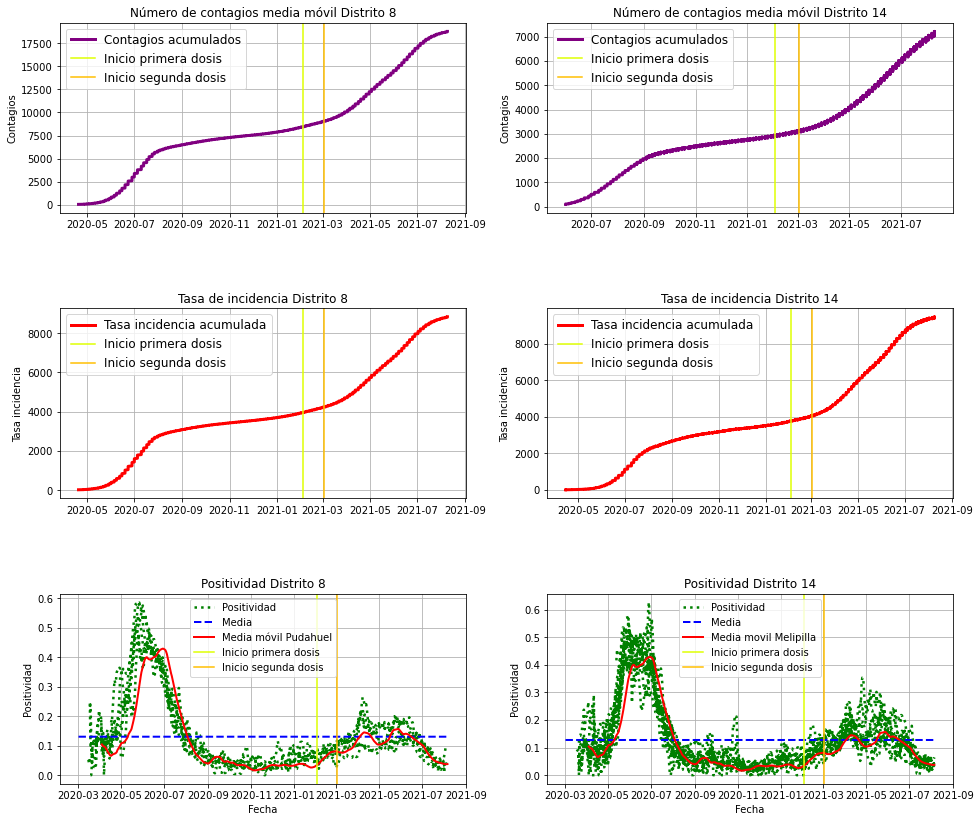

In [51]:
x1 = df_Distrito_8['Fecha']
y1 = df_Distrito_8['Casos_comfirmados_8']
x2 = df_Distrito_14['Fecha']
y2 = df_Distrito_14['Casos_comfirmados_14']
x3 = tasa_dis8['Fecha']
y3 = tasa_dis8['Tasa_de_incidencia8']
x4 = tasa_dis14['Fecha']
y4 = tasa_dis14['Tasa_de_incidencia14']
x5 = positividad_dis8['fecha']
y5 = positividad_dis8['positividad']
x6 = positividad_dis14['fecha']
y6 = positividad_dis14['positividad']
x7_8 = pos_Pudahuel['fecha']
y7_8 = pos_Melipilla['media_Melipilla']
x8_14 = pos_Pudahuel['fecha']
y8_14 = pos_Melipilla['media_Melipilla']

fig, axs = plt.subplots(3,2,figsize=(16, 14))
fig.subplots_adjust(hspace=0.5)
y_mean5 = [np.mean(y5)]*len(x5)
y_mean6 = [np.mean(y6)]*len(x6)

axs[0,0].plot(x1, y1, ls='-', lw=3, c='purple', label='Contagios acumulados')
axs[0,0].set_ylabel('Contagios')
axs[0,0].set_title("Número de contagios media móvil Distrito 8")
axs[0,0].axvline(pd.Timestamp('2021-02-03'),color='#DFFF00', label='Inicio primera dosis')
axs[0,0].axvline(pd.Timestamp('2021-03-03'),color='#FFBF00', label='Inicio segunda dosis')
axs[0,0].grid()
axs[0,0].legend(fontsize=12)
axs[0,1].plot(x2, y2, ls='-', lw=3, c='purple',label='Contagios acumulados')
axs[0,1].set_ylabel('Contagios')
axs[0,1].set_title("Número de contagios media móvil Distrito 14")
axs[0,1].axvline(pd.Timestamp('2021-02-03'),color='#DFFF00', label='Inicio primera dosis')
axs[0,1].axvline(pd.Timestamp('2021-03-03'),color='#FFBF00', label='Inicio segunda dosis')
axs[0,1].grid()
axs[0,1].legend(fontsize=12)
axs[1,0].plot(x3, y3, ls='-', lw=3, c='red',label='Tasa incidencia acumulada')
axs[1,0].set_ylabel('Tasa incidencia')
axs[1,0].set_title("Tasa de incidencia Distrito 8")
axs[1,0].axvline(pd.Timestamp('2021-02-03'),color='#DFFF00', label='Inicio primera dosis')
axs[1,0].axvline(pd.Timestamp('2021-03-03'),color='#FFBF00', label='Inicio segunda dosis')
axs[1,0].grid()
axs[1,0].legend(fontsize=12)
axs[1,1].plot(x4, y4, ls='-', lw=3, c='red',label='Tasa incidencia acumulada')
axs[1,1].set_ylabel('Tasa incidencia')
axs[1,1].set_title("Tasa de incidencia Distrito 14")
axs[1,1].axvline(pd.Timestamp('2021-02-03'),color='#DFFF00', label='Inicio primera dosis')
axs[1,1].axvline(pd.Timestamp('2021-03-03'),color='#FFBF00', label='Inicio segunda dosis')
axs[1,1].grid()
axs[1,1].legend(fontsize=12)
axs[2,0].plot(x5, y5, ls=':', lw=2.5, c='green',label='Positividad')
axs[2,0].set_ylabel('Positividad')
axs[2,0].set_xlabel('Fecha')
axs[2,0].set_title("Positividad Distrito 8")
axs[2,0].plot(x5, y_mean5, color='blue', lw=2, ls='--', label='Media')
axs[2,0].plot(x7_8, y7_8, color='red', lw=2, ls='-', label='Media móvil Pudahuel')
axs[2,0].axvline(pd.Timestamp('2021-02-03'),color='#DFFF00', label='Inicio primera dosis')
axs[2,0].axvline(pd.Timestamp('2021-03-03'),color='#FFBF00', label='Inicio segunda dosis')
axs[2,0].grid()
axs[2,0].legend(fontsize=10, loc=9)
axs[2,1].plot(x6, y6, ls=':', lw=2.5, c='green',label='Positividad')
axs[2,1].set_ylabel('Positividad')
axs[2,1].set_xlabel('Fecha')
axs[2,1].set_title("Positividad Distrito 14")
axs[2,1].plot(x6, y_mean6, color='blue', lw=2, ls='--', label='Media')
axs[2,1].plot(x8_14, y8_14, color='red', lw=2, ls='-', label='Media movil Melipilla')
axs[2,1].axvline(pd.Timestamp('2021-02-03'),color='#DFFF00', label='Inicio primera dosis')
axs[2,1].axvline(pd.Timestamp('2021-03-03'),color='#FFBF00', label='Inicio segunda dosis')
axs[2,1].grid()
axs[2,1].legend(fontsize=10, loc=9)
plt.show();